
Using the SQL database approach, compare manta data with model results, varying
the averaging period and the max age.

**v01:** try adapting this to each category separately, see if the model shows difference in loss rates.

**v02:** use a single smoothing value (10), and generate more streamlined plots.

**v03:** Try bringing in the landuse variability.

**v04:** Pull the particle data once (with a given smoothing and overall time window), shove it all into a big ugly matrix, write to netcdf, and operate just on that matrix for more flexible data fitting.

Manta data is already adjusted by category, and the category-level data is in the csv.

Load data...

In [1]:
import os
import time
from collections import defaultdict
import six

import time

import logging as log
import glob
import re

import seaborn as sns
from matplotlib import colors, cm
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.colors import LogNorm

import numpy as np

import pandas as pd
import xarray as xr

from sqlite3 import dbapi2 as sql

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.spatial import proj_utils 
from stompy.model.data_comparison import calc_metrics
from stompy.plot import plot_wkb
from stompy.model import data_comparison
import stompy.plot.cmap as scmap
from scipy import stats


import postprocess_v00 as post

%matplotlib notebook

In [2]:
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')

In [106]:
# Load the manta data, clean it up
manta_fn='manta_summary-v03.csv'
manta=pd.read_csv(manta_fn)
manta.head()

,SampleID,SAMPLE LOCATION,DATE,TYPE,LAT START,LONG START,LAT END,LONG END,TOTAL DIST (M),START FLOW,...,part_per_m3_std,part_per_m2_std,part_per_m3_raw_std,part_per_m2_raw_std,part_per_m3_nofiber,part_per_m2_nofiber,part_per_m3_raw_nofiber,part_per_m2_raw_nofiber,x,y
0,CB-4-Manta-21Aug2017,CB4,2017-08-21 00:00:00,Manta,37.915567,-122.441217,37.941933,-122.419983,3473.323262,NaN,...,0.224191,0.021298,0.442172,0.042006,0.015526,0.001475,0.024841,0.002360,550040.331073,4.198063e+06
1,SPB3-Manta-21Aug2017,SPB3,2017-08-21 00:00:00,Manta,38.023072,-122.371583,38.042133,-122.321883,66678.222270,9113.0,...,1.817781,0.172689,1.928407,0.183199,0.296678,0.028184,0.301706,0.028662,557329.971756,4.209634e+06
2,SUB1-Manta-21Aug2017,SUB1,2017-08-21 00:00:00,Manta,38.107067,-122.056283,38.096533,-122.064917,1393.740434,128369.0,...,NaN,NaN,0.000000,0.000000,0.032671,0.003104,0.039205,0.003724,582363.556136,4.217527e+06
3,SPB2-Manta-21Aug2017,SPB2,2017-08-21 00:00:00,Manta,38.051283,-122.421750,38.023000,-122.428117,3194.008847,220135.0,...,0.210549,0.020002,0.402882,0.038274,0.021966,0.002087,0.034288,0.003257,550464.046320,4.210092e+06
4,CB9-Manta-22Aug2017,CB9,2017-08-22 00:00:00,Manta,37.687233,-122.290917,37.698500,-122.298433,1416.656380,290000.0,...,0.085947,0.008165,0.174186,0.016548,0.085947,0.008165,0.091677,0.008709,562183.425087,4.171973e+06


In [107]:
len(manta)

65

In [4]:
import sql_common
import glob, os, six
import postprocess_v00 as post
six.moves.reload_module(sql_common)

# try to run everything that can be cached and re-used through
# here. 

<module 'sql_common' from '/home/rusty/src/microplastic_sfbay/postprocess/sql_common.py'>

In [5]:
PtmSet=sql_common.PtmSetNew
ptm_base="/opt2/sfb_ocean/ptm/all_source_021b"
dbs=glob.glob(os.path.join(ptm_base,"20*/ptm_and_grid.db"))
dbs.sort()
ptm_set=PtmSet(databases=dbs)

In [7]:
six.moves.reload_module(post)

<module 'postprocess_v00' from '/home/rusty/src/microplastic_sfbay/postprocess/postprocess_v00.py'>

In [8]:
g=ptm_set.grid()

In [9]:
# Get all of the group names so loads can be premapped
group_names=[]
for db in ptm_set.databases:
    con=ptm_set.db_to_con(db)
    curs=con.cursor()
    curs.execute("select name from ptm_group group by name")
    group_names.append( np.array([t[0] for t in curs.fetchall()],'S100') )
group_names=np.unique(np.concatenate(group_names)) # ensures sort, too
print(f"{len(group_names)} groups in total")

10584 groups in total


In [10]:
g_poly=g.boundary_polygon()

@memoize.memoize()
def stencil0(c):
    stencil=np.zeros(g.Ncells(),np.float64)
    stencil[c]=1.0
    return stencil

@memoize.memoize()
def stencil1(c):
    return ptm_set.smooth(stencil0(c))

INFO:join_features:0 open strings, 25 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=38109911619.298943, 24 potential interiors


In [11]:
# For each trawl, I want to query all of the particles 
# that were "nearby" at a "near time", and get their
# release time, cell, std mass, and nofiber mass.
# from there, it's postprocessing to see what subset or
# weighting of those gives the best agreement with
# part_per_m2_std and part-per_m2_raw

In [12]:
# Is it possible to run the query once, and save enough info about the
# particles to apply loading scenarios after the fact?

def query_particles(t_start,t_stop,
                    z_filter="and loc.z_from_surface>-0.095",
                    max_age=np.timedelta64(20,'D'),
                    grp_filter=""):
    epoch_start=int( utils.to_unix( t_start ) )
    epoch_stop =int( utils.to_unix( t_stop ) )
    max_age_clause=f"and (loc.time-rel.time)<{int(max_age/np.timedelta64(1,'s'))}"

    # So rather than multiplying out the loads here, 
    # record rel.volume/rel.count to get rel_part_volume 
    query=f"""
      select rel.volume / rel.count as rel_part_volume,
             loc.time as time,
             rel.time as rel_time,
             loc.cell as cell,
             grp.name as grp
        from particle_loc as loc, particle as p, ptm_release as rel, 
             ptm_group as grp
        where loc.time>={epoch_start} and loc.time < {epoch_stop}
          and loc.particle_id=p.id
          and p.release_id=rel.id
          and rel.group_id=grp.id
          and loc.cell>=0
          {max_age_clause}
          {z_filter}
          {grp_filter}"""
    print(query)    
    
    query_dtype=[('rel_part_volume',np.float64),
                 ('time',np.int32),
                 ('rel_time',np.int32),
                 ('cell',np.int32),
                 ('group','S100')]

    all_data=[]
    all_data.append( np.zeros(0,dtype=query_dtype) )

    for db in ptm_set.databases:
        con=ptm_set.db_to_con(db)
        curs=con.cursor()
        curs.execute(query)
        data=curs.fetchall()
        print(f"{db} {len(data)} rows")
        if len(data)==0: continue
        adata=np.array(data)

        adata2=np.zeros(len(adata),dtype=query_dtype)
        adata2['rel_part_volume']=adata[:,0]
        adata2['time']=adata[:,1].astype(np.int32)
        adata2['rel_time']=adata[:,2].astype(np.int32)
        adata2['cell']=adata[:,3].astype(np.int32)
        adata2['group']=adata[:,4]
        all_data.append(adata2)

    combined=np.concatenate( all_data )
    return combined

In [13]:
out_dir="manta_sets_20200330c"
# now the 021b runs.
# c suffix: use tighter -0.095 z filter.
# 20200227: start of v03
# 20200302: start of v04
# 20200305: try larger window -- extra 24 hours in both directions.
# 20200312: new sources in ptm data, with v02 stormwater concs.
# 20200330: more new sources.
os.makedirs(out_dir,exist_ok=True)

for idx,rec in manta.iterrows():
    # since we're just pulling out whole days, cache by day.
    # and pull through the end of that day
    fn=os.path.join(out_dir,f"v01-{rec.DATE[:10]}.npy")
    
    if os.path.exists(fn):
        print(f"{fn} exists. Skipping")
        continue

    # pull a generous buffer of particles here, and narrow
    # the time zones are annoying but I double-checked and
    # This does give enough of a buffer.
    t_sample=np.datetime64(rec.DATE)
    # want to be able to, after the fact, query a full 25h tidal cycle
    # centered on the actual time of a sample that could fall anywhere
    # in this day.
    t_start=t_sample+np.timedelta64(8,'h') - np.timedelta64(12,'h')
    # and go for a tidal day
    t_stop =t_sample+np.timedelta64(8+24,'h') + np.timedelta64(13,'h')
    query_n_steps=25 # how many hours are included in the query.

    # 2020305 changes:
    t_start-=np.timedelta64(24,'h')
    t_stop+=np.timedelta64(24,'h')
    query_n_steps += 48
    
    combined=query_particles(t_start,t_stop)
    np.save(fn,combined)


manta_sets_20200330c/v01-2017-08-21.npy exists. Skipping
manta_sets_20200330c/v01-2017-08-21.npy exists. Skipping
manta_sets_20200330c/v01-2017-08-21.npy exists. Skipping
manta_sets_20200330c/v01-2017-08-21.npy exists. Skipping
manta_sets_20200330c/v01-2017-08-22.npy exists. Skipping
manta_sets_20200330c/v01-2017-08-22.npy exists. Skipping
manta_sets_20200330c/v01-2017-08-22.npy exists. Skipping
manta_sets_20200330c/v01-2017-08-22.npy exists. Skipping
manta_sets_20200330c/v01-2017-08-23.npy exists. Skipping
manta_sets_20200330c/v01-2017-08-23.npy exists. Skipping
manta_sets_20200330c/v01-2017-08-23.npy exists. Skipping
manta_sets_20200330c/v01-2017-08-23.npy exists. Skipping
manta_sets_20200330c/v01-2017-08-24.npy exists. Skipping
manta_sets_20200330c/v01-2017-08-24.npy exists. Skipping
manta_sets_20200330c/v01-2017-08-24.npy exists. Skipping
manta_sets_20200330c/v01-2017-08-25.npy exists. Skipping
manta_sets_20200330c/v01-2017-08-25.npy exists. Skipping
manta_sets_20200330c/v01-2017-0

In [14]:
load_names_all= [ b"_".join( g.split(b'_')[:-1] )
                  for g in group_names ]
load_names=np.unique(load_names_all)
print(f"{len(load_names)} unique loads")

# and loop again to get the mapping
group_to_load_idx={}

for g,l in zip(group_names,load_names_all):
    group_to_load_idx[g]=np.searchsorted(load_names,l)

378 unique loads


In [108]:
manta.head()

,SampleID,SAMPLE LOCATION,DATE,TYPE,LAT START,LONG START,LAT END,LONG END,TOTAL DIST (M),START FLOW,...,part_per_m3_std,part_per_m2_std,part_per_m3_raw_std,part_per_m2_raw_std,part_per_m3_nofiber,part_per_m2_nofiber,part_per_m3_raw_nofiber,part_per_m2_raw_nofiber,x,y
0,CB-4-Manta-21Aug2017,CB4,2017-08-21 00:00:00,Manta,37.915567,-122.441217,37.941933,-122.419983,3473.323262,NaN,...,0.224191,0.021298,0.442172,0.042006,0.015526,0.001475,0.024841,0.002360,550040.331073,4.198063e+06
1,SPB3-Manta-21Aug2017,SPB3,2017-08-21 00:00:00,Manta,38.023072,-122.371583,38.042133,-122.321883,66678.222270,9113.0,...,1.817781,0.172689,1.928407,0.183199,0.296678,0.028184,0.301706,0.028662,557329.971756,4.209634e+06
2,SUB1-Manta-21Aug2017,SUB1,2017-08-21 00:00:00,Manta,38.107067,-122.056283,38.096533,-122.064917,1393.740434,128369.0,...,NaN,NaN,0.000000,0.000000,0.032671,0.003104,0.039205,0.003724,582363.556136,4.217527e+06
3,SPB2-Manta-21Aug2017,SPB2,2017-08-21 00:00:00,Manta,38.051283,-122.421750,38.023000,-122.428117,3194.008847,220135.0,...,0.210549,0.020002,0.402882,0.038274,0.021966,0.002087,0.034288,0.003257,550464.046320,4.210092e+06
4,CB9-Manta-22Aug2017,CB9,2017-08-22 00:00:00,Manta,37.687233,-122.290917,37.698500,-122.298433,1416.656380,290000.0,...,0.085947,0.008165,0.174186,0.016548,0.085947,0.008165,0.091677,0.008709,562183.425087,4.171973e+06


In [109]:
# So we now have all particles for time windows around each
# manta sample, with some slop, and bounded age of 20 days.

# M*L = predicted

# L: loading data, L(location,settling class) ~ particles/m3.

# Where should age come in?

# The matrix rows correspond to manta samples (any need to further
# divide the output rows?)
# The matrix columns correspond to all combinations of 
# location x settling for loads into the model.

# There remains the question of where to account for variable
# age.  Either age adjustment is accounted for ahead of construction
# of the matrix, or I need effectively (20*24) copies of this matrix
# There are 33 input locations (8 potws, 25 stormwater),
# and 7 settling classes, so loads are set at 231 columns.

# There are 65 manta samples
# So at the very least, we've got a matrix that's (65, 231)
# with 15k entries.
# If I enumerate all ages, then the matrix has 7.2M entries.
# not too crazy, but enough to be annoying. That's a 58MB
# netcdf file.
# Create the matrix in 3-D, ravel later.

mat_ds=xr.Dataset()
mat_ds['load']=('load',),load_names # combination of location and settling rate
mat_ds['manta']=('manta',),manta['SampleID']
mat_ds['age']=('age',), np.arange(20*24)
mat_ds['age'].attrs['units']='h'

In [110]:
M=np.zeros( (mat_ds.dims['manta'],mat_ds.dims['load'],mat_ds.dims['age']),np.float64)

#smooth=10 # yields 174690 nonzero entrie, 2.4% of all entries
smooth=50
hours_min=-13
hours_max=12
nsteps=hours_max-hours_min
mat_ds['smooth']=(),smooth
mat_ds['hours_max']=(),hours_max
mat_ds['hours_min']=(),hours_min
mat_ds['nsteps']=(),nsteps
# f: -2,2 hours
# g: -13,12 hours
mat_ds['version']=(),'20200305g'


for row_idx,rec in utils.progress(manta.iterrows()):
    # since we're just pulling out whole days, cache by day.
    # and pull through the end of that day
    fn=os.path.join(out_dir,f"v01-{rec.DATE[:10]}.npy")
    particles=np.load(fn)
    
    # Stencil weighting:
    g=ptm_set.grid()
    c_select=g.select_cells_nearest(np.r_[rec.x,rec.y])
    stencil=stencil0(c_select)
    Ms=ptm_set.Msmooth()
    for s in range(smooth):
        stencil=Ms.dot(stencil)
    # This sets the units -- particles per m2
    cell_weight=stencil/g.cells_area()/nsteps

    # calculate age index
    age_h=(particles['time'] - particles['rel_time'])/3600. # 0 to 479.0
    age_idx = age_h.astype(np.int32)
    assert age_idx.min() >=0
    assert age_idx.max() < mat_ds.dims['age']

    # calculate load index
    load_idx=np.array( [group_to_load_idx[g] for g in particles['group']] )

    # link particles to manta concentration

    # starting point is:
    part_weights=particles['rel_part_volume'] * cell_weight[particles['cell']]

    # time of observation relative to the time of the manta sample.
    relative_time_h=(particles['time']-utils.to_unix(rec.time_utc))/3600.0
    part_weights[relative_time_h<hours_min]=0.0
    part_weights[relative_time_h>hours_max]=0.0

    valid=np.nonzero(part_weights)[0] # typ 0.1% of all particles
    for p in valid:
        M[row_idx,load_idx[p],age_idx[p]] += part_weights[p]

INFO:utils:2
INFO:utils:4
INFO:utils:6
INFO:utils:8
INFO:utils:10
INFO:utils:12
INFO:utils:14
INFO:utils:16
INFO:utils:18
INFO:utils:20
INFO:utils:22
INFO:utils:24
INFO:utils:26
INFO:utils:28
INFO:utils:29
INFO:utils:30
INFO:utils:32
INFO:utils:34
INFO:utils:36
INFO:utils:38
INFO:utils:40
INFO:utils:42
INFO:utils:44
INFO:utils:46
INFO:utils:48
INFO:utils:50
INFO:utils:52
INFO:utils:54
INFO:utils:56
INFO:utils:58
INFO:utils:60
INFO:utils:62
INFO:utils:64


In [111]:
mat_ds['M']=('manta','load','age'),M
mat_ds['M'].attrs['units']='particles m-3'

In [112]:
# expand the load names to source and ws
beh_to_ws={b'down50000':0.05,
           b'down5000':0.005,
           b'down500':0.0005,
           b'none':0,
           b'up500':-0.0005,
           b'up5000':-0.005,
           b'up50000':-0.05}

wss=[]
sources=[]
for load in mat_ds['load'].values:
    ws=beh_to_ws[ load.split(b'_')[-1] ]
    source= b'_'.join( load.split(b'_')[:-1] )
    wss.append(ws)
    sources.append(source)

mat_ds['w_s']=('load',),wss
mat_ds['w_s'].attrs['units']='m s-1'
mat_ds['w_s'].attrs['positive']='down'
mat_ds['source']=('load',),sources

In [113]:
# Load the loads
loads_orig=xr.open_dataset("../loads/plastic_loads-7classes-v05.nc")

# And the per-watershed scaling factor
storm_scales=pd.read_csv("../loads/stormwater_concs-v02.csv")

# Get rid of the extra fields in loads -- otherwise we have to fabricate
# them for the watersheds
loads=loads_orig.copy()

for fld in ['n_blank_particles','n_blank_samples','blank_rate',
            'total_volume','n_samples','count_w_s','count_no_w_s',
            'conc_raw','conc_noclip','conc_blank','blank_derate']:
    del loads[fld]

# Extend loads_orig with storm_scales
storm_conc=loads_orig['conc'].sel(source='stormwater')
storm_conc_net=storm_conc.values.sum()
storm_conc_net # 8.50 particles/l

watershed_conc=np.zeros( (len(storm_scales),loads_orig.dims['category'],loads_orig.dims['w_s']))
# bui(source, category, w_s) 
for storm_i,storm_scale in storm_scales.iterrows():
    watershed_conc[storm_i,:,:] = storm_conc.values * storm_scale['net_coeff_scaled'] / storm_conc_net
    
watershed_loads=xr.Dataset()
watershed_loads['source']=('source',),storm_scales['source']
watershed_loads['conc']=('source','category','w_s'),watershed_conc
watershed_loads['source_pathway']=('source',),['stormwater']*len(storm_scales)
watershed_loads['pathway']=loads_orig['pathway']

loads=xr.concat( (loads,watershed_loads), dim='source')

# drop 'stormwater' to catch potential bugs later
loads=loads.isel(source=(loads.source!='stormwater'))

In [114]:
source_map=dict()
source_map[b'cccsd']=b'CCCSD'
source_map[b'sunnyvale']=b'SUNN'
source_map[b'fs']=b'FSSD'
source_map[b'palo_alto']=b'PA'
source_map[b'san_jose']=b'SJ'
source_map[b'src000']=b'EBDA'
source_map[b'src001']=b'EBMUD'
source_map[b'src002']=b'SFPUC'
# these we don't actually use
source_map[b'petaluma']=b'SKIP'
source_map[b'sonoma_valley']=b'SKIP'
source_map[b'SacRiver']=b'SKIP'
source_map[b'SJRiver']=b'SKIP'
source_map[b'Islais_Creek']=b'SKIP' # SF - routes to SFPUC.
source_map[b'Black_Point']=b'SKIP'  # same
for s in mat_ds['source'].values:
    if s not in source_map:
        source_map[s]=s

In [115]:
# Assemble load vector
def load_vector(load_da,mat_ds,wastewater_scale=1/0.70,stormwater_scale=1.0):
    load_vec=np.zeros(mat_ds.dims['load'],np.float64)

    sources=mat_ds['source'].values
    wss=mat_ds['w_s'].values

    missing_loads=[]
    
    for load_i in range(mat_ds.dims['load']):
        source=sources[load_i]
        w_s=wss[load_i]

        # Names are slightly different between loads and sources
        source_name=source_map[source].decode()

        if source_name == 'SKIP':
            load_vec[load_i]=0.0
        else:
            if source_name not in load_da.source.values:
                if source_name not in missing_loads:
                    missing_loads.append(source_name)
                continue
            conc=load_da.sel(source=source_name,w_s=w_s).item()

            if source_name=='stormwater':
                conc*=stormwater_scale
            else:
                conc*=wastewater_scale

            # load netcdf is in particles/l, but we want to set the calculation
            # up as particle/m3. Updated 2019-11-17
            conc*=1000
            load_vec[load_i]=conc
    if missing_loads:
        print("Missing loads -- probably update storm_landuse_v02")
        print("\n".join(missing_loads))
        raise Exception("Some loads are missing")
    load_vec=xr.DataArray( load_vec, coords=[ ('load',mat_ds['load'])])
    return load_vec

In [116]:
# Choose particle category
vers=mat_ds['version'].item()

if 0:
    #   spearman is almost constant.
    #   log_r shows mostly a smooth=2 signal, but not that much variation.
    #   r has a great pattern. but the values are about 0.25, and it's almost
    #     certainly driven by a few large values, so not that convincing.
    manta_field='part_per_m2_std'
    load_da=loads.conc.sum(dim='category')
    sub_vers=vers+"std"
if 1:
    # non-fibers:
    #   quite similar to previous code.  tau=2 from pearson or log-r.
    #   amp suggests 1.0d, but the manta size class issue easily justifies
    #   saying this could be 2.0days.
    manta_field='part_per_m2_nofiber'
    # TODO: the above actually includes Fiber Bundles, which probably ought to
    # be omitted with fibers.  for some data, Fiber Bundles were not counted 
    # separate from fibers.
    load_sel=(loads.category.values != 'Fiber')&(loads.category.values!='Fiber Bundle')
    load_da=loads.isel(category=load_sel).conc.sum(dim='category')
    sub_vers=vers+"nofiber"
if 0:
    # films - pretty terrible.  amplitude suggests 3-4 days.
    # correlations are screwy, and show the worst correlations at
    # that same time scale.
    manta_field='part_per_m2_film'
    manta[manta_field]=manta['Fiber_adj']/manta['area_m2']
    load_sel=(loads.category.values == 'Film')
    load_da=loads.isel(category=load_sel).conc.sum(dim='category')
    sub_vers=vers+"film"
if 0:
    # fragments - this one does look quite similar to the nofiber
    # data.  amplitude ~ 1 day, spearman ~ 3 days
    manta_field='part_per_m2_fragment'
    manta[manta_field]=manta['Fragment_adj']/manta['area_m2']
    load_sel=(loads.category.values == 'Fragment')
    load_da=loads.isel(category=load_sel).conc.sum(dim='category')
    sub_vers=vers+"fragment"
if 0:
    # just fibers!  spearman says shortest tau, least smoothing
    # log(amp) says a bit less than 1 day.
    # wilmott says 0.5 days
    manta_field='part_per_m2_fiber'
    manta[manta_field]=(manta['Fiber_adj']+manta['Fiber Bundle_adj'])/manta['area_m2']
    load_sel=(loads.category.values == 'Fiber')|(loads.category.values=='Fiber Bundle')
    load_da=loads.isel(category=load_sel).conc.sum(dim='category')
    sub_vers=vers+"fiber"
if 0:
    # foam - spearman says full smoothing, shortest tau
    # amplitude says 1-2 days
    manta_field='part_per_m2_foam'
    manta[manta_field]=manta['Foam_adj']/manta['area_m2']
    load_sel=(loads.category.values == 'Foam')
    load_da=loads.isel(category=load_sel).conc.sum(dim='category')
    sub_vers=vers+"foam"
if 0:
    # sphere
    manta_field='part_per_m2_sphere'
    manta[manta_field]=manta['Sphere_adj']/manta['area_m2']
    load_sel=(loads.category.values == 'Sphere')
    load_da=loads.isel(category=load_sel).conc.sum(dim='category')
    sub_vers=vers+"sphere"
    
sub_vers=sub_vers+'_smooth%d'%( mat_ds['smooth'].item())

In [117]:
# smooth is baked into M.
taus=np.array([0.5,1,2,3,4,5,7.5,10,15,20]) * 86400

all_results=[]
per_trawls=[]

smooths=[mat_ds['smooth'].item()]

for tau in taus:
    # mat_ds['M'] ~ manta x load x age
    tau_h=tau/3600.
    age_fac=xr.DataArray( np.exp(-mat_ds['age']/tau_h),
                          dims=['age'])
    load_vec=load_vector(load_da,mat_ds)
    pred=((mat_ds['M']*age_fac).sum(dim='age') * load_vec).sum(dim='load').values
    obs=manta[manta_field]

    per_trawl=manta.copy()
    per_trawl['predicted']=pred
    per_trawls.append(per_trawl)

    valid=np.isfinite(obs)
    pred=pred[valid]
    obs=obs[valid]

    metrics=calc_metrics( xr.DataArray(pred), xr.DataArray(obs))
    metrics['smooth']=smooth
    metrics['tau']=tau
    metrics['dataset']=sub_vers

    metrics['log_r']=np.corrcoef( np.log10(pred.clip(1e-6)), np.log10(obs.clip(1e-6)))[1,0]
    all_results.append(metrics)

df=pd.DataFrame(all_results)
df.to_csv(f"parameter-scan-{sub_vers}.csv")

/opt/anaconda3/envs/general/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


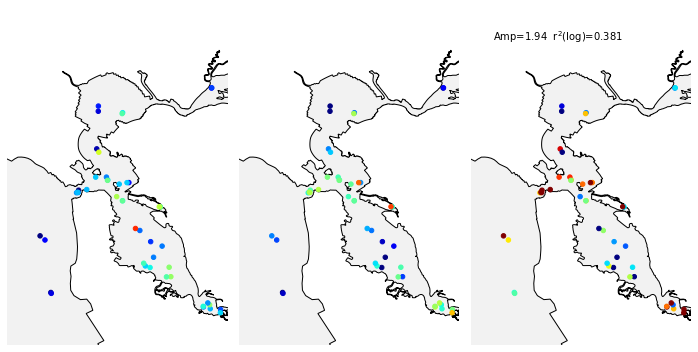

In [118]:
# Look at the spatial distribution of errors
# manual tinkering 
smooths=[mat_ds['smooth'].item()]

tau=2*86400

# mat_ds['M'] ~ manta x load x age
tau_h=tau/3600.
min_age_fac=0.001
age_fac=xr.DataArray( np.exp(-mat_ds['age']/tau_h).clip(min_age_fac),
                      dims=['age'])
load_vec=load_vector(load_da,mat_ds)
pred=((mat_ds['M']*age_fac).sum(dim='age') * load_vec).sum(dim='load').values
obs=manta[manta_field]

per_trawl=manta.copy()
per_trawl['predicted']=pred

valid=np.isfinite(obs)
pred=pred[valid]
obs=obs[valid]

metrics=calc_metrics( xr.DataArray(pred), xr.DataArray(obs))
metrics['smooth']=smooth
metrics['tau']=tau
metrics['dataset']=sub_vers

metrics['log_r']=np.corrcoef( np.log10(pred.clip(1e-6)), np.log10(obs.clip(1e-6)))[1,0]

amp=metrics['amp']

# ----
fig,axs=plt.subplots(1,3,sharex=True,sharey=True,figsize=(9.5,5))

for ax in axs:
    #g.plot_edges(color='k',lw=0.4,ax=ax)
    plot_wkb.plot_wkb(g_poly,edgecolor='k',facecolor='0.95',ax=ax,zorder=-5)
    ax.axis('off')

err=np.log10( per_trawl['predicted']/amp / per_trawl['part_per_m2_nofiber'] )

scats=[
    axs[0].scatter( per_trawl['x'], per_trawl['y'],20,
                    np.log10(per_trawl['part_per_m2_nofiber']),cmap='jet'),
    axs[1].scatter( per_trawl['x'], per_trawl['y'],20,
                    np.log10(per_trawl['predicted']/amp),cmap='jet'),
    axs[2].scatter( per_trawl['x'], per_trawl['y'],20,err,cmap='jet')
]

scats[0].set_clim([-3,1])
scats[1].set_clim([-3,1])
scats[2].set_clim([-1,1])
fig.tight_layout()
axs[0].axis( (524799.9206707922, 586959.838715973, 4135420.4930665633, 4243617.948999238) )

axs[2].text(0.1,0.9,f"Amp={amp:.2f}  r$^2( \log )$={metrics['log_r']**2:.3f}",
            transform=axs[2].transAxes)

fig.subplots_adjust(left=0.,right=1)

Text(0, 0.5, 'Model')

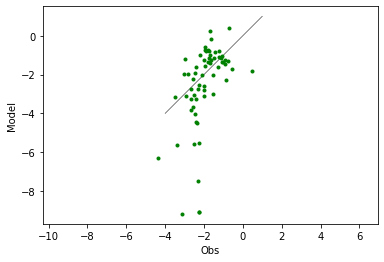

In [119]:
## And a scatter plot
fig2,ax_s=plt.subplots(1,1)
ax_s.plot(np.log10(per_trawl['part_per_m2_nofiber']),
          np.log10(per_trawl['predicted']/amp),
         'g.')
ax_s.axis('equal')
ax_s.plot([-4,1],[-4,1],'k-',lw=0.5,zorder=-1)
ax_s.set_xlabel('Obs')
ax_s.set_ylabel('Model')

In [120]:
df=pd.read_csv(f'parameter-scan-{sub_vers}.csv')
df['tau_d']=df.tau/86400.

In [121]:
df['log_r2']=df.log_r**2
df.loc[:,['amp','log_r2','murphy','r','spearman_rho','tau_d']]

,amp,log_r2,murphy,r,spearman_rho,tau_d
0,0.290351,0.343451,-0.104446,-0.000572,0.658785,0.5
1,0.817052,0.376105,-0.660135,0.004698,0.660446,1.0
2,1.935639,0.379643,-3.842989,0.013804,0.642701,2.0
3,2.954733,0.362990,-9.174812,0.016041,0.628584,3.0
4,3.782685,0.347873,-15.251692,0.016274,0.619930,4.0
5,4.446544,0.338769,-21.282190,0.015941,0.610621,5.0
6,5.621666,0.327169,-34.560145,0.014700,0.590385,7.5
7,6.383485,0.314465,-45.000832,0.013627,0.584353,10.0
8,7.307897,0.300971,-59.672091,0.012163,0.566608,15.0
9,7.847352,0.294018,-69.273688,0.011260,0.556949,20.0


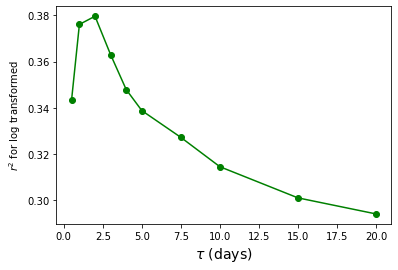

In [122]:
field='log_r'
nice_field='$r^2$ for log transformed'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

fig,ax=plt.subplots(1,1)
if len(smooths)>1:
    hm=sns.heatmap(as_matrix**2, annot=True)
    ax.set_ylabel('Smoothing iterations',fontsize=14)
    cax=fig.axes[1]
    cax.set_ylabel(nice_field,fontsize=14)
    plt.subplots_adjust(bottom=0.15,top=0.95,right=0.9)
else:
    ax.plot(df['tau_d'],df[field]**2,'g-o')
    ax.set_ylabel(nice_field)
ax.set_xlabel(r'$\tau$ (days)',fontsize=14)
fig.savefig(f'manta_compare_log_r2-{sub_vers}.png',dpi=200)



In [31]:
# roughly, looking at 10 day output, South Bay is mostly underpredicted
# except near shore.
# GG and coastal ocean overpredicted.
# LSB overpredicted.
# Suisun, Richmond overpredicted.
# Far coast underpredicted.
# So either there are particles out there that didn't come from the Bay, or 
# we need some fraction of particles that live longer.

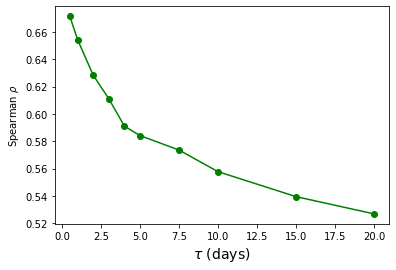

In [32]:
field='spearman_rho'
nice_field=r'Spearman $\rho$'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

fig,ax=plt.subplots(1,1)
if len(smooths)>1:
    hm=sns.heatmap(as_matrix, annot=True)
    ax.set_ylabel('Smoothing iterations',fontsize=14)
    cax=fig.axes[1]
    cax.set_ylabel(nice_field,fontsize=14)
    plt.subplots_adjust(bottom=0.15,top=0.95,right=0.9)
else:
    ax.plot(df['tau_d'],df[field],'g-o')
    ax.set_ylabel(nice_field)
ax.set_xlabel(r'$\tau$ (days)',fontsize=14)
fig.savefig(f'manta_compare_spearman_rho-{sub_vers}.png',dpi=200)

In [ ]:
df['log_amp']=np.log10(df.amp)
field='log_amp'
nice_field='log$_{10}$(amp)'


fig,ax=plt.subplots(1,1)
if len(smooths)>1:
    as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()
    hm=sns.heatmap(as_matrix, annot=True,cmap='coolwarm',ax=ax,
                   cbar_kws=dict(label=field),vmin=-1,vmax=1)
    plt.subplots_adjust(bottom=0.15,top=0.95,right=0.9)
    ax.set_ylabel('Smoothing iterations',fontsize=14)
    cax=fig.axes[1]
    cax.set_ylabel(nice_field,fontsize=14)
else:
    ax.plot(df['tau_d'],df[field],'g-o')
    ax.set_ylabel(nice_field)
    ax.axhline(0,color='k',lw=0.5)
    
ax.set_xlabel(r'$\tau$ (days)',fontsize=14)
fig.savefig(f'manta_compare_log10amp-{sub_vers}.png',dpi=200)


In [ ]:
field='wilmott'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

plt.figure()
hm=sns.heatmap(as_matrix, annot=True,cbar_kws=dict(label=field))
plt.subplots_adjust(bottom=0.25)

In [ ]:
field='r'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

plt.figure()
hm=sns.heatmap(as_matrix, annot=True,cbar_kws=dict(label=field))
plt.subplots_adjust(bottom=0.25)

In [ ]:
field='murphy'

as_matrix=df.set_index(['smooth','tau_d'])[field].unstack()

plt.figure()
hm=sns.heatmap(as_matrix, annot=True,cbar_kws=dict(label=field))
plt.subplots_adjust(bottom=0.25)

In [ ]:
# Any improvement by aggregating trawls?
per_trawls[0].head()

In [33]:
def analyze_medians(df):
    dfm=df.loc[:,['region','obs','predicted']].melt(id_vars=['region']).set_index(['region','variable'])

    dfm.sort_index(inplace=True)

    def p_total(f):
        # Maximize the combined median test
        p_tot=1.0
        for region in ['CB','NB','SB','NMS']:
            obs=dfm.loc[ (region,'obs'), 'value']
            mod=f*dfm.loc[ (region,'predicted'), 'value']
            # is it better to choose just the modeled data where the observation
            # is valid?
            stat,p,M,cont=stats.median_test( obs[np.isfinite(obs)] ,
                                             mod[np.isfinite(mod)] )
            p_tot*=p
        return p_tot

    def cost(p):
        return -p_total( 10**p )

    from scipy.optimize import brute

    best=brute(cost,[[-4,1]],Ns=51)
    scale=10**best[0]
    p_tot=p_total(scale)
    print(f"P-total: {p_tot:.3f}  with scale: {1/scale:5f}")
    return p_tot,scale

In [123]:
# Group samples - Central Bay, North Bay, South Bay, NMS.
def loc_to_region(s):
    if s.startswith('SPB') or s.startswith('SUB'): return 'NB'
    if s.startswith('SB') or s.startswith('LSB'): return 'SB'
    if s.startswith('GFNMS') or s.startswith('MBNMS') or s.startswith('CBNMS'): 
        return 'NMS'
    if s.startswith('CB') or s=='SFBay': return 'CB'
    raise Exception("No match for %s"%s)

Tau: 0.5
P-total: 0.000  with scale: 0.100000
0.5 days: ampl. error: 0.100 Median test net p: 0.00013

Tau: 1.0


/opt/anaconda3/envs/general/lib/python3.7/site-packages/pandas/core/indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


P-total: 0.007  with scale: 0.398107
1.0 days: ampl. error: 0.398 Median test net p: 0.00708

Tau: 2.0


/opt/anaconda3/envs/general/lib/python3.7/site-packages/pandas/core/indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


P-total: 0.031  with scale: 0.501187
2.0 days: ampl. error: 0.501 Median test net p: 0.03125

Tau: 3.0


/opt/anaconda3/envs/general/lib/python3.7/site-packages/pandas/core/indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


P-total: 0.117  with scale: 1.258925
3.0 days: ampl. error: 1.259 Median test net p: 0.11709

Tau: 4.0


/opt/anaconda3/envs/general/lib/python3.7/site-packages/pandas/core/indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


P-total: 0.226  with scale: 1.995262
4.0 days: ampl. error: 1.995 Median test net p: 0.22574

Tau: 5.0


/opt/anaconda3/envs/general/lib/python3.7/site-packages/pandas/core/indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


P-total: 0.226  with scale: 3.162278
5.0 days: ampl. error: 3.162 Median test net p: 0.22574

Tau: 7.5


/opt/anaconda3/envs/general/lib/python3.7/site-packages/pandas/core/indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


P-total: 0.163  with scale: 5.011872
7.5 days: ampl. error: 5.012 Median test net p: 0.16282

Tau: 10.0


/opt/anaconda3/envs/general/lib/python3.7/site-packages/pandas/core/indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


P-total: 0.163  with scale: 5.011872
10.0 days: ampl. error: 5.012 Median test net p: 0.16282

Tau: 15.0


/opt/anaconda3/envs/general/lib/python3.7/site-packages/pandas/core/indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


P-total: 0.163  with scale: 5.011872
15.0 days: ampl. error: 5.012 Median test net p: 0.16282

Tau: 20.0


/opt/anaconda3/envs/general/lib/python3.7/site-packages/pandas/core/indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


P-total: 0.163  with scale: 6.309573
20.0 days: ampl. error: 6.310 Median test net p: 0.16282



/opt/anaconda3/envs/general/lib/python3.7/site-packages/pandas/core/indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


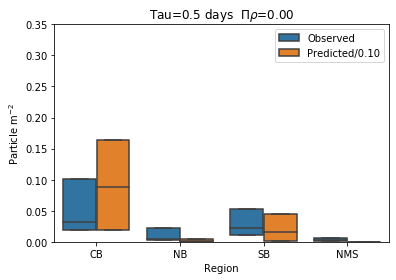

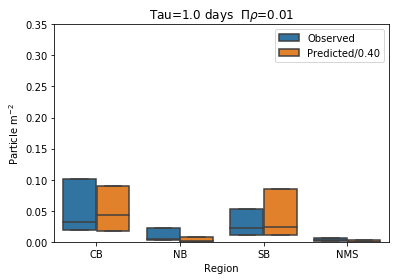

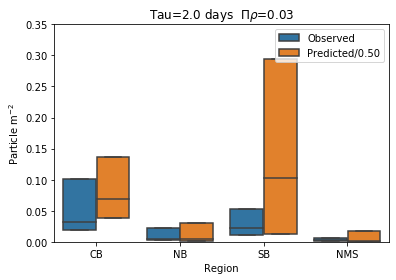

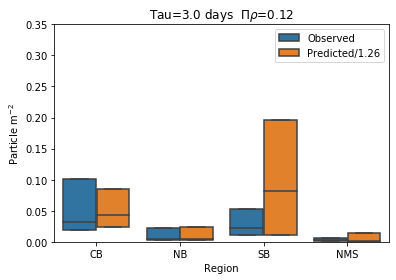

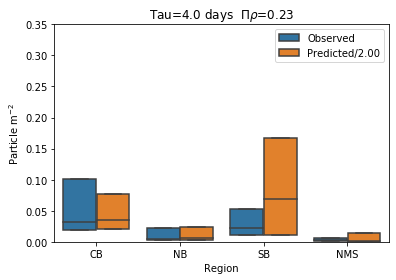

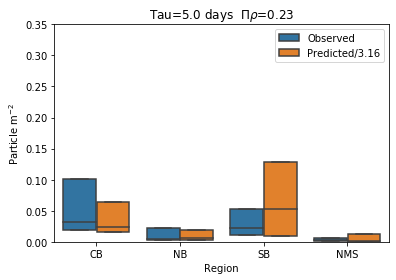

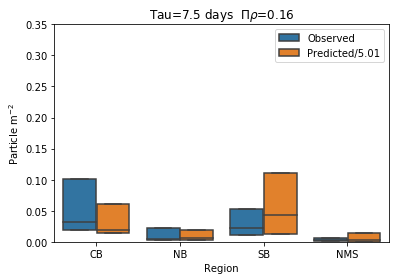

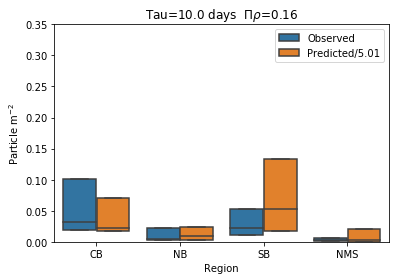

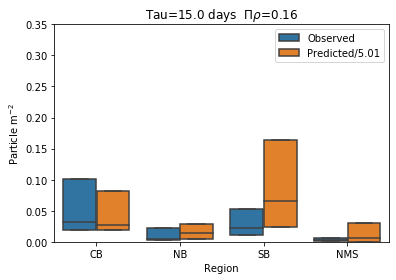

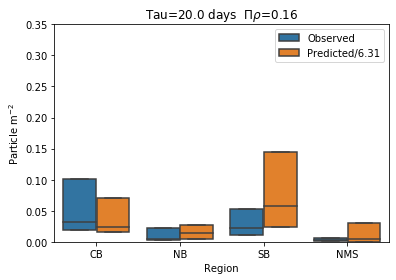

In [34]:
    
for tau,df in zip(taus,per_trawls):
    print(f"Tau: {tau/86400.}")
    df=df[ df[manta_field].notnull() ].copy()
    
    regions=df['region']=df['SAMPLE LOCATION'].apply(loc_to_region)
    df=df.rename(columns={manta_field:'obs'}).loc[:,['region','obs','predicted']]

    # Scale gets optimized to find the best nonparametric match
    p_tot,scale=analyze_medians(df)

    # This is not rigorous!
    obs_mag=1.0
    pred_mag=1/scale
    
    df['obs_frac']=df['obs'] / obs_mag
    df['pred_frac']=df['predicted'] / pred_mag

    dfm=df.loc[:,['region','obs_frac','pred_frac']].melt(id_vars=['region'])

    fig,ax=plt.subplots(1,1)# ,figsize=(10,3))
    sns.boxplot(x='region',y='value',hue='variable',data=dfm,fliersize=0,whis=0,
                ax=ax,bootstrap=1000)
    ax.axis(ymax=0.35,ymin=0)
    ax.legend(ax.artists,['Observed',f'Predicted/{pred_mag:.2f}'],loc='upper right')
    ax.set_ylabel('Particle m$^{-2}$')
    ax.set_xlabel('Region')
    
    ax.set_title(f'Tau={tau/86400.} days  $\\Pi \\rho$={p_tot:.2f}')
    df2=dfm.set_index(['region','variable'])
    p_tot=1.0
    for region in ['CB','NB','SB','NMS']:
        stat,p,M,cont=stats.median_test( df2.loc[ (region,'obs_frac'), 'value'] ,
                                         df2.loc[ (region,'pred_frac'), 'value'] )
        p_tot*=p
    print(f"{tau/86400.} days: ampl. error: {pred_mag/obs_mag:.3f} Median test net p: {p_tot:.5f}")
    
    print()
    fig.savefig(f'manta_comp_v04-tau{tau/86400}.png',dpi=200)

In [ ]:
# With the updated loads, the overall amplitude error is way better -
# down to 10x or less.
# The fit itself is not great, and the time scales are even shorter than
# before.

Tau: 7.5


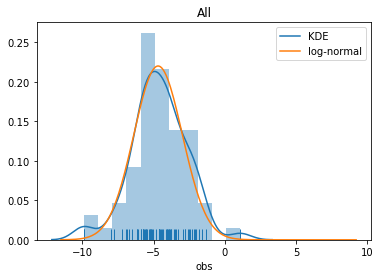

In [85]:
# Can I fit a distribution to the per-region data, in order
# to then go Bayesian?
for tau,df in zip(taus,per_trawls):
    if tau/86400.>7:
        break
    
print(f"Tau: {tau/86400.}")
regions=df['region']=df['SAMPLE LOCATION'].apply(loc_to_region)
df=df.rename(columns={manta_field:'obs'}).loc[:,['region','obs','predicted']]

#for region in regions.unique():
#    fig=plt.figure()
#    sns.distplot(df['obs'][df['region']==region],rug=True)
#    fig.axes[0].set_title(region)

# one for all of the data:
fig=plt.figure()
sns.distplot(np.log(df['obs'].clip(5e-5)),
             rug=True,kde_kws=dict(gridsize=200,label='KDE'))
ax=fig.axes[0]
ax.set_title('All')

# Manually tune some distributions
x=np.logspace(-5,4,200)

logx=np.log(x)
mu=-1.8
sig=1.7
dens_lognorm=1/(x*sig*np.sqrt(2*np.pi)) * np.exp(- (logx-mu)**2/(2*sig**2))
dens_lognorm = 0.22* dens_lognorm / dens_lognorm.max()
ax.plot(logx,dens_lognorm,label='log-normal')

# ax.plot(logx,stats.chi.pdf(x,1,loc=0,scale=1),label='chi')
# ax.plot(logx, stats.gamma.pdf(x,1.4,scale=0.06)/40,label='$\Gamma$')

ax.legend(loc='upper right')

In [116]:
# *if* I assume that
# log-normal is a reasonable distribution...
# Then how would a Bayesian model be structured?
# Goal is to estimate 
# (a) loss timescale, and
# (b) the manta undercounting factor
# along the way maybe have to fit some mean concentrations?

# Pick up here -- instead of median test, go for a simple Bayesian 
# model per-subembayment.

In [124]:
regions

array(['CB', 'NB', 'NB', 'NB', 'CB', 'CB', 'CB', 'CB', 'SB', 'SB', 'SB',
       'SB', 'SB', 'SB', 'SB', 'CB', 'CB', 'NMS', 'NMS', 'NMS', 'NMS',
       'NMS', 'NMS', 'NMS', 'NMS', 'NMS', 'CB', 'NMS', 'NMS', 'NMS', 'CB',
       'CB', 'NB', 'CB', 'CB', 'CB', 'CB', 'CB', 'NB', 'NB', 'NMS', 'NMS',
       'CB', 'CB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB',
       'NMS', 'NMS', 'NMS', 'NMS', 'NMS', 'NMS', 'NMS', 'NMS', 'NMS',
       'NMS', 'NMS', 'NMS'], dtype=object)

In [125]:
manta.Season.unique() # why is there only dry season??

array(['Dry', 'Wet'], dtype=object)

In [126]:
regions

array(['CB', 'NB', 'NB', 'NB', 'CB', 'CB', 'CB', 'CB', 'SB', 'SB', 'SB',
       'SB', 'SB', 'SB', 'SB', 'CB', 'CB', 'NMS', 'NMS', 'NMS', 'NMS',
       'NMS', 'NMS', 'NMS', 'NMS', 'NMS', 'CB', 'NMS', 'NMS', 'NMS', 'CB',
       'CB', 'NB', 'CB', 'CB', 'CB', 'CB', 'CB', 'NB', 'NB', 'NMS', 'NMS',
       'CB', 'CB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB',
       'NMS', 'NMS', 'NMS', 'NMS', 'NMS', 'NMS', 'NMS', 'NMS', 'NMS',
       'NMS', 'NMS', 'NMS'], dtype=object)

In [127]:
# Try out some emcee
import emcee

load_vec=load_vector(load_da,mat_ds)

obs=manta[manta_field].values
valid=np.isfinite(obs)
obs=obs[valid]

regions=manta['SAMPLE LOCATION'].apply(loc_to_region).values[valid]
seasons=manta['Season'].values[valid]
regions=["%s-%s"%(r,s) for r,s in zip(regions,seasons)]

region_uniq=np.unique(regions)
region_nums=np.searchsorted(region_uniq,regions)
region_groups=list(utils.enumerate_groups(region_nums))

def forward_model(tau_d,amp):
    # mat_ds['M'] ~ manta x load x age
    tau_h=tau_d*24
    min_age_fac=0.00
    age_fac=xr.DataArray( np.exp(-mat_ds['age']/tau_h).clip(min_age_fac),
                          dims=['age'])
    pred=((mat_ds['M']*age_fac).sum(dim='age') * load_vec).sum(dim='load').values

    pred=pred[valid]/amp
    return pred

min_conc=np.nanmin( obs[obs>0.0] )

def log_likelihood(tau,amp):
    ll=0.0
    #obs_var=np.var( np.log(obs.clip(min_conc)))
    
    pred=forward_model(tau,amp)
    for reg,idxs in region_groups:
        obs_mu = np.mean( np.log(obs[idxs].clip(min_conc)))
        obs_var = np.var( np.log(obs[idxs].clip(min_conc)))

        ll -= np.sum( (np.log(pred[idxs].clip(min_conc))-obs_mu)**2/obs_var )
    return ll

log_likelihood(4,3)

-303.3573724638708

In [68]:
from scipy.optimize import fmin

fmin(lambda x: -log_likelihood(x[0],x[1]), [2,2])

array([1.39707112e+15, 2.33167481e+01])

In [136]:
taus=np.linspace(0.5,20,20)
amps=np.linspace(0.5,40,10)

T,A=np.meshgrid(taus,amps)

lls=np.zeros_like(T)

for idx in np.ndindex(*T.shape):
    lls[idx]=log_likelihood(T[idx],A[idx])
    

Text(0, 0.5, 'Amp')

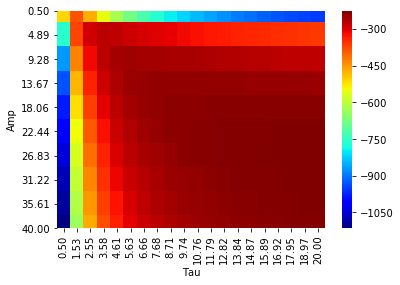

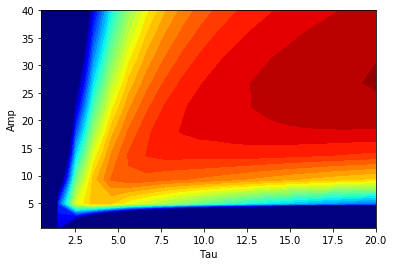

In [137]:
fig,ax=plt.subplots(1,1)

import seaborn as sns
sns.heatmap(lls,
            xticklabels=["%.2f"%x for x in taus],
            yticklabels=["%.2f"%x for x in amps],
            #vmin=-200,vmax=-160,
           cmap='jet')
ax.set_xlabel('Tau')
ax.set_ylabel('Amp')
#plt.colorbar()

fig,ax=plt.subplots(1,1)
ax.contourf(taus,amps,lls,np.linspace(-400,-220,30),extend='min',cmap='jet')
ax.set_xlabel('Tau')
ax.set_ylabel('Amp')
#plt.colorbar()

In [ ]:
# Try out some emcee
import emcee

load_vec=load_vector(load_da,mat_ds)

obs=manta[manta_field]
valid=np.isfinite(obs)
obs=obs[valid]

def forward_model(tau,amp):
    # mat_ds['M'] ~ manta x load x age
    tau_h=tau/3600.
    min_age_fac=0.00
    age_fac=xr.DataArray( np.exp(-mat_ds['age']/tau_h).clip(min_age_fac),
                          dims=['age'])
    pred=((mat_ds['M']*age_fac).sum(dim='age') * load_vec).sum(dim='load').values

    pred=pred[valid]
    return pred


HERE...

    
def log_prob(x, ivar):
    return -0.5 * np.sum(ivar * x ** 2)

ndim, nwalkers = 5, 100
ivar = 1. / np.random.rand(ndim)
p0 = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[ivar])
sampler.run_mcmc(p0, 10000)


In [140]:
manta.DATE.unique()

array(['2017-08-21 00:00:00', '2017-08-22 00:00:00',
       '2017-08-23 00:00:00', '2017-08-24 00:00:00',
       '2017-08-25 00:00:00', '2017-09-11 00:00:00',
       '2017-09-12 00:00:00', '2017-09-13 00:00:00',
       '2017-09-18 00:00:00', '2017-09-27 00:00:00',
       '2017-11-05 00:00:00', '2017-11-16 00:00:00',
       '2017-11-17 00:00:00', '2018-01-11 00:00:00',
       '2018-03-19 00:00:00', '2018-03-06 00:00:00',
       '2018-03-29 00:00:00', '2018-03-30 00:00:00',
       '2018-03-31 00:00:00'], dtype=object)

In [158]:
# chunks are 2018-06-20 and onwards, every 10 days.
chunk_starts=np.arange(np.datetime64("2017-06-20"),
                       np.datetime64("2018-04-20"),
                      np.timedelta64(10*86400,'s'))


chunk_usage=np.zeros(len(chunk_starts),np.int32)
for d in manta.DATE.unique():
    d=np.datetime64(d)
    d_early=d-np.timedelta64(20,'D')
    chunk_usage[ np.searchsorted(chunk_starts,d_early)-1:
                 np.searchsorted(chunk_starts,d)-1] += 1



tab=pd.DataFrame(dict(start=chunk_starts,usage=chunk_usage))
tab

,start,usage
0,2017-06-20,0
1,2017-06-30,0
2,2017-07-10,0
3,2017-07-20,0
4,2017-07-30,5
5,2017-08-09,5
6,2017-08-19,4
7,2017-08-29,5
8,2017-09-08,1
9,2017-09-18,0


In [163]:
np.datetime64("2018-03-23",'s') 

numpy.datetime64('2018-03-23T00:00:00')